In [1]:
# test importing main packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import pandas as pd
import subprocess
import fnmatch
import os
import sys
import gsw
import cmocean as ocm
from netCDF4 import Dataset
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# new packages
import eofs
import lmfit
import iris
import nc_time_axis
import plotly

os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

/opt/conda/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
!python --version

Python 3.6.7


In [3]:
sys.version

'3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 09:07:38) \n[GCC 7.3.0]'

In [4]:
!pip --version

pip 19.0.3 from /opt/conda/lib/python3.6/site-packages/pip (python 3.6)


In [5]:
print("numpy version: ", np.__version__)
print("matplotlib version: ", mpl.__version__)
print("xarray version: ", xr.__version__)
print("pandas version: ", pd.__version__)


numpy version:  1.14.3
matplotlib version:  3.0.3
xarray version:  0.12.0
pandas version:  0.24.2


In [6]:
import bokeh
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [7]:
print("bokeh version: ", bokeh.__version__)

bokeh version:  1.0.4


In [8]:
from dask.distributed import Client
#client = Client("tcp://127.0.0.1:41129")
client = Client()
client


Client Scheduler: tcp://127.0.0.1:46507 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 33.60 GB


In [9]:
atmxr = xr.open_dataset("TS.nc", chunks={'time': 10}, decode_times=False)
ocnxr = xr.open_dataset("T_S_PD.nc", chunks={'time': 10}, decode_times=False)


In [10]:
atmxr

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 1)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) float64 3.701e+05
Dimensions without coordinates: nbnd
Data variables:
    TS         (time, lat, lon) float32 dask.array<shape=(1, 192, 288), chunksize=(1, 192, 288)>
    time_bnds  (time, nbnd) float64 dask.array<shape=(1, 2), chunksize=(1, 2)>
Attributes:
    Conventions:    CF-1.0
    source:         CAM
    title:          UNSET
    climo_script:   ncclimo
    climo_version:  4.6.2-alpha02
    NCO:            netCDF Operators version 4.7.7 (Homepage = http://nco.sf....
    history:        Tue Feb 26 10:59:46 2019: ncatted -a history,global,d,, T...

In [11]:
ocnxr

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1, z_t: 1)
Coordinates:
    TLAT        (nlat, nlon) float64 dask.array<shape=(384, 320), chunksize=(384, 320)>
    TLONG       (nlat, nlon) float64 dask.array<shape=(384, 320), chunksize=(384, 320)>
  * time        (time) float64 1.465e+06
  * z_t         (z_t) float32 500.0
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    PD          (time, z_t, nlat, nlon) float32 dask.array<shape=(1, 1, 384, 320), chunksize=(1, 1, 384, 320)>
    SALT        (time, z_t, nlat, nlon) float32 dask.array<shape=(1, 1, 384, 320), chunksize=(1, 1, 384, 320)>
    TEMP        (time, z_t, nlat, nlon) float32 dask.array<shape=(1, 1, 384, 320), chunksize=(1, 1, 384, 320)>
    time_bound  (time, d2) float64 dask.array<shape=(1, 2), chunksize=(1, 2)>
Attributes:
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2

In [12]:
grid_in = {'lon': ocnxr['TLONG'], 'lat': ocnxr['TLAT']}
grid_out = {'lon': atmxr['lon'], 'lat': atmxr['lat']}
regridder = xe.Regridder(grid_in, grid_out, 'nearest_s2d', reuse_weights=False)


Overwrite existing file: nearest_s2d_384x320_192x288.nc 
 You can set reuse_weights=True to save computing time.


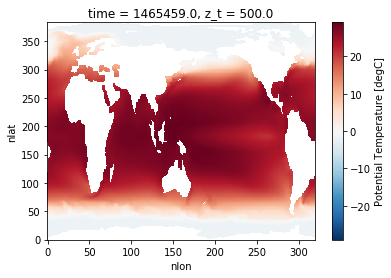

In [13]:
ocnxr["TEMP"][0,0,:,:].plot()

In [14]:
ocntemp_on_atm_grid = regridder(ocnxr["TEMP"][0,0,:,:])


In [15]:
ocntemp_on_atm_grid

<xarray.DataArray 'TEMP' (lat: 192, lon: 288)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-1.791345, -1.791345, -1.791345, ..., -1.791295, -1.791315, -1.791345],
       [-1.791631, -1.791631, -1.791631, ..., -1.791631, -1.791631, -1.791631],
       [-1.792805, -1.792805, -1.792805, ..., -1.792805, -1.792805, -1.792805]])
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Attributes:
    regrid_method:  nearest_s2d

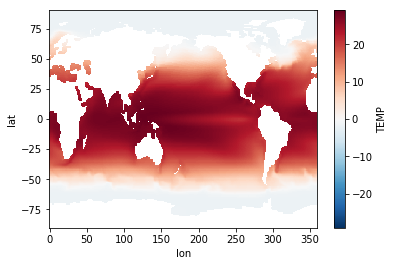

In [16]:
ocntemp_on_atm_grid.plot()

In [17]:
# add cyclic point
atm_temp_cy, lons_cy = add_cyclic_point(ocntemp_on_atm_grid, atmxr['lon'])


/opt/conda/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning:

Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip



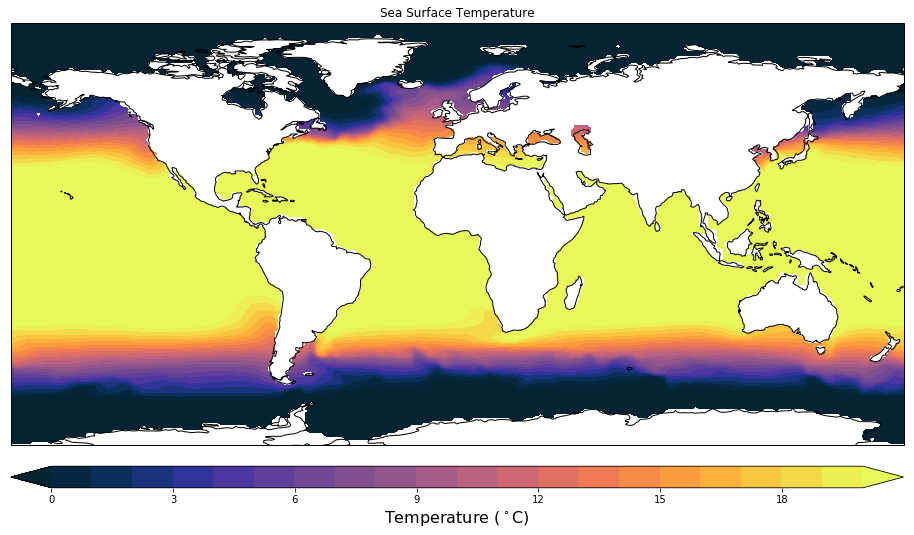

In [18]:
# test cartopy
fig = plt.figure(figsize=(16,10))


saltmap = ocm.cm.haline
tempmap = ocm.cm.thermal
pdmap = ocm.cm.dense
saltdiffmap = ocm.cm.delta
tempdiffmap = ocm.cm.curl
pddiffmap = ocm.cm.tarn

##### temperature
#####
ax0 = plt.subplot(111, projection=ccrs.PlateCarree())

p1a = ax0.contourf(lons_cy, atmxr['lat'], atm_temp_cy,
                 cmap = tempmap, levels = np.linspace(0,20,21), extend='both')

ax0.coastlines()
#ax.set_global()
ax0.set_extent([-180, 180, -80 , 90])
#plt.colorbar(p1a)
plt.title("Sea Surface Temperature")

### colorbars
pos = ax0.get_position()
l, b, w, h = pos.bounds
cbarxoffset=0.0
cbaryoffset=-0.06
ctax1 = fig.add_axes([l+cbarxoffset, b+cbaryoffset, w*1, 0.03]) # setup colorbar axes
cb1=fig.colorbar(p1a,cax=ctax1, orientation='horizontal') # draw colorbar
cbarstrc1='Temperature ($^\circ$C)'
cb1.set_label(cbarstrc1, fontsize=16, y=0.5)


In [19]:
pd0_from_gsw = gsw.sigma0(ocnxr["SALT"], ocnxr["TEMP"])

In [20]:
pd0_gsw = pd0_from_gsw.squeeze()

In [21]:
pd0_gsw.shape

(384, 320)

In [22]:
pd0_gsw_on_atm_grid = regridder(pd0_gsw)

In [23]:
# put into density anomaly units
model_pd0_on_atm_grid = regridder(ocnxr["PD"][0,0,:,:]*1000.0 - 1000.0)

In [24]:
# numpy array
pd0_gsw_on_atm_grid

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [26.56205806, 26.56205806, 26.56205806, ..., 26.58502556,
        26.58860592, 26.56205806],
       [26.51465972, 26.51465972, 26.51465972, ..., 26.51465972,
        26.51465972, 26.51465972],
       [26.41150525, 26.41150525, 26.41150525, ..., 26.41150525,
        26.41150525, 26.41150525]])

In [25]:
# xarray dataarray
model_pd0_on_atm_grid

<xarray.DataArray 'PD' (lat: 192, lon: 288)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [26.71167 , 26.71167 , 26.71167 , ..., 26.734863, 26.738159, 26.71167 ],
       [26.664551, 26.664551, 26.664551, ..., 26.664551, 26.664551, 26.664551],
       [26.560791, 26.560791, 26.560791, ..., 26.560791, 26.560791, 26.560791]])
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Attributes:
    regrid_method:  nearest_s2d

In [26]:
# add cyclic point
atmgrid_gsw_pd0_cy, lons_cy = add_cyclic_point(pd0_gsw_on_atm_grid, atmxr['lon'])
atmgrid_model_pd0_cy, lons_cy = add_cyclic_point(model_pd0_on_atm_grid, atmxr['lon'])


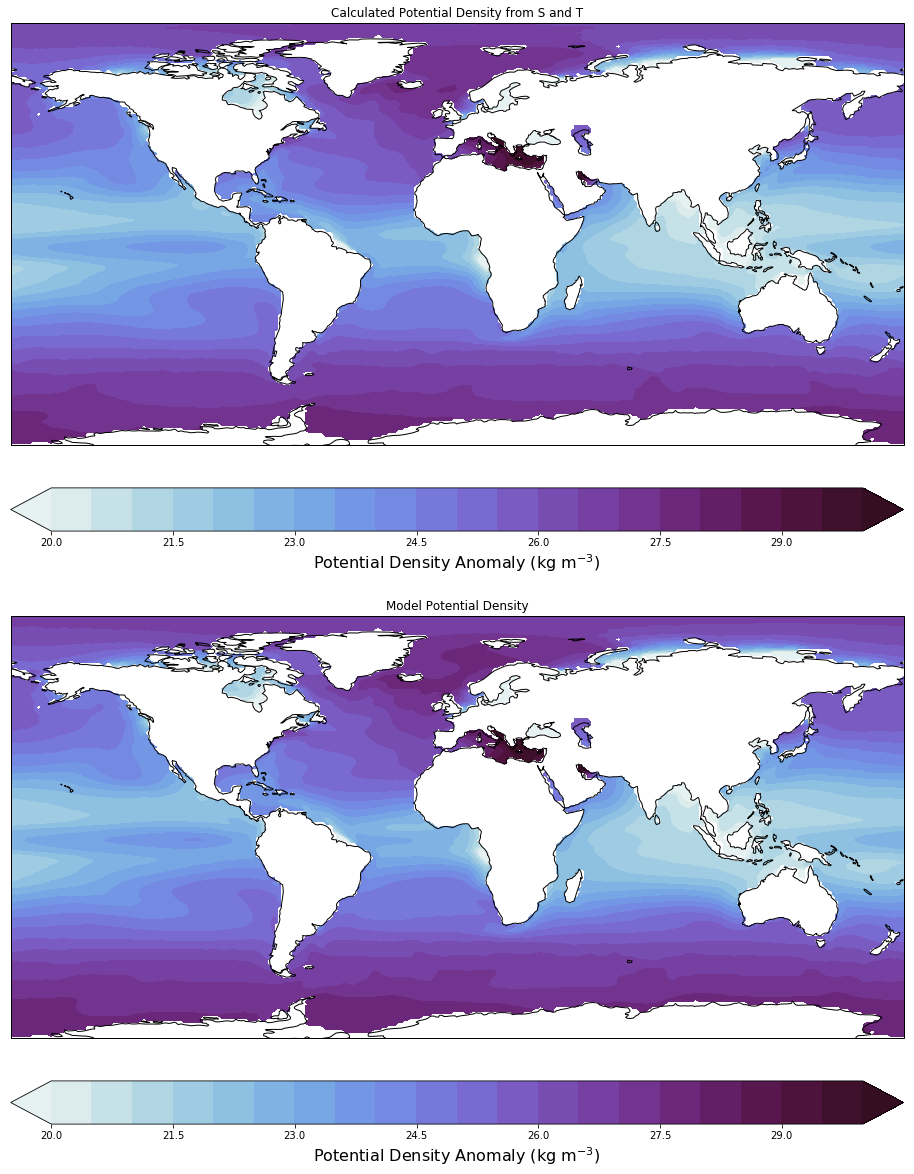

In [27]:
# test cartopy
fig = plt.figure(figsize=(16,20))


saltmap = ocm.cm.haline
tempmap = ocm.cm.thermal
pdmap = ocm.cm.dense
saltdiffmap = ocm.cm.delta
tempdiffmap = ocm.cm.curl
pddiffmap = ocm.cm.tarn

##### potential density calculated
#####
ax0 = plt.subplot(211, projection=ccrs.PlateCarree())

p1a = ax0.contourf(lons_cy, atmxr['lat'], atmgrid_gsw_pd0_cy,
                 cmap = pdmap, levels = np.linspace(20,30,21), extend='both')

ax0.coastlines()
#ax.set_global()
ax0.set_extent([-180, 180, -80 , 90])
#plt.colorbar(p1a)
plt.title("Calculated Potential Density from S and T")

### colorbars
pos = ax0.get_position()
l, b, w, h = pos.bounds
cbarxoffset=0.0
cbaryoffset=-0.06
ctax1 = fig.add_axes([l+cbarxoffset, b+cbaryoffset, w*1, 0.03]) # setup colorbar axes
cb1=fig.colorbar(p1a,cax=ctax1, orientation='horizontal') # draw colorbar
cbarstrc1='Potential Density Anomaly (kg m$^{-3}$)'
cb1.set_label(cbarstrc1, fontsize=16, y=0.5)


##### potential density from model
#####
ax1 = plt.subplot(212, projection=ccrs.PlateCarree())

p2a = ax1.contourf(lons_cy, atmxr['lat'], atmgrid_model_pd0_cy,
                 cmap = pdmap, levels = np.linspace(20,30,21), extend='both')

ax1.coastlines()
#ax1.set_global()
ax1.set_extent([-180, 180, -80 , 90])
#plt.colorbar(p1a)
plt.title("Model Potential Density")

### colorbars
pos = ax1.get_position()
l, b, w, h = pos.bounds
cbarxoffset=0.0
cbaryoffset=-0.06
ctax2 = fig.add_axes([l+cbarxoffset, b+cbaryoffset, w*1, 0.03]) # setup colorbar axes
cb2=fig.colorbar(p2a,cax=ctax2, orientation='horizontal') # draw colorbar
cbarstrc2='Potential Density Anomaly (kg m$^{-3}$)'
cb2.set_label(cbarstrc2, fontsize=16, y=0.5)
